# Data Analysis of P2P market as MAD problem
We evaluate the results of the simulation of a prosumer participating in a fully decentralized P2P market. This work is modelled as Multi-armed Bandit problem, a classic control problem that we can apply RL techniques.

This analysis starts by looking to the results presented in the Informs talk as ''Prosumer choice formulatedas Multi Armed Bandit problem - RL application''

In [12]:
# Import packages
import numpy as np
import pandas as pd
import pickle as pkl
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

Start with upload the simulations done for the Informs talk that shows the first results with this work:

In [13]:
# Read pickle file
wok_dir = Path.cwd()
filename = 'sim_results_fixed_target_15_exp_replay.pkl'
path_file = wok_dir / filename
data = pkl.load(open(path_file, 'rb')) # Read file
# Plot parameters
plt_colmap = plt.get_cmap("tab10", 15)
sns.set_style("whitegrid")

# Add the success rate - Important for later
df = data['outcome']
no_agents = len(df)
for i in range(no_agents):
    gamma = df[i]['total_rd'] / df[i]['final_step']
    df[i].insert(2, 'gamma_rate', gamma, True)
data['outcome'] = df

In [14]:
## Define Plot functions

# Plot the reward per episode and RL_agent
def plot_reward_per_episode(df_score, y_feat, plt_label, plt_marker, size=(10,8), y_sum=False):
    # Get the plot parameters
    no_RL_agents = len(df_score)
    no_episodes = df_score[0].shape[0]
    plt.figure(figsize=size)
    x = np.arange(0, no_episodes)
    for i in range(no_RL_agents):
        y = df_score[i][y_feat]
        y = np.cumsum(y) if y_sum else y
        plt.plot(x, y, label=plt_label[i], marker=plt_marker[i], linestyle='--')
        
# Plot the theta per episode and RL_agent
def plot_theta_per_episode(df_score, theta, plt_label, n_bins=20, size=(10,8)):
    from statsmodels.distributions.empirical_distribution import ECDF
    # Get the plot parameters
    no_RL_agents = len(df_score)
    no_episodes = df_score[0].shape[0]
    fig, axis = plt.subplots(1, 2, figsize=size, sharex=True)
    x = np.arange(0, no_episodes)
    for i in range(no_RL_agents):
        x = df_score[i][theta]
        axis[0].hist(x, density=True, bins=n_bins, label=plt_label[i])
        ecdf = ECDF(x)
        axis[1].plot(ecdf.x, ecdf.y, label=plt_label[i]) 
    return fig, axis

## Total reward $R_{Total}$ evolution per episode
Total reward plot for all episodes with the following conditions:
 - The same Energy_target = 15 kWh for all episodes. 
 - Non-existing correlation, i.e. episodes are independent from each other
 - **Goal:** Evaluate the learning process of each policy (Random, Epsilon-greedy, Thompson-Sampler). If the *Epsilon-greedy* and *Thompson-Sampler* beat **constantly** the *Random policy*

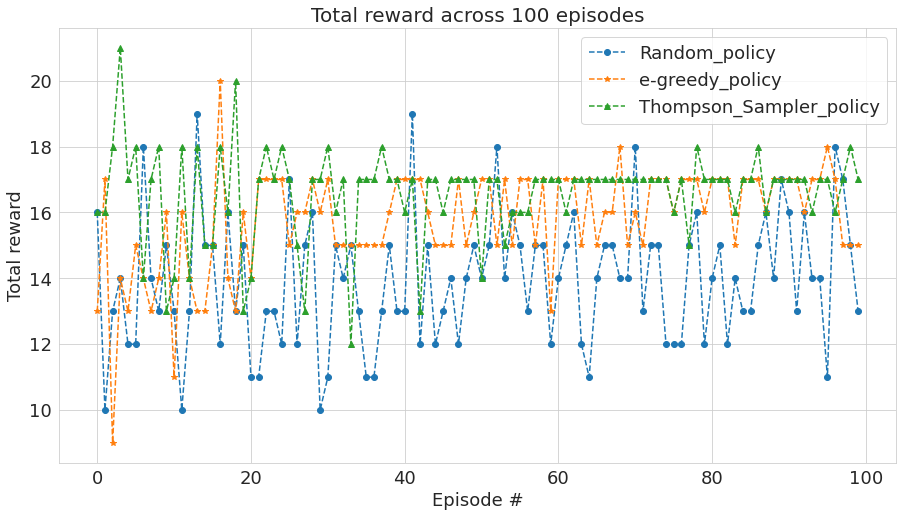

In [15]:
no_epi = data['simulation']['episodes']
label = data['agents']['id']
marker = ['o', '*', '^']
ax_label = ['Episode #', 'Total reward']
ax_size = 18
plot_reward_per_episode(data['outcome'], 'total_rd', label, marker, (15,8))
# Legend and labels for the plot
plt.legend(fontsize=ax_size)
plt.ylabel(ax_label[1], fontsize=ax_size)
plt.xticks(fontsize=ax_size)
plt.yticks(fontsize=ax_size)
plt.xlabel(ax_label[0], fontsize=ax_size)
plt.title(f'Total reward across {no_epi} episodes', fontsize=20)
plt.show()

The plot shows weird behavior of the total reward per policy:
- Random policy gets better total_reward in specific episodes (around episodes **20** and **60**)
- This effect may be of the total reward $R_{Total}$ is agnostic to the state $s_n$ value
- State $s_n$ is equal to the sum of energy $E_j(a_n = j)$ accepted so far
***
The reward $R_n$ is computed as, assuming action $a_n$ selected offer $j$, <br>
$
R_n = \left\{\begin{array}{ll}
    1 ,& \quad B(\sigma_{a_n = j}) = 1 \\
    0 ,& \quad \text{otherwise} \\
\end{array}\right.
$ <br>
where, the total reward is $R_{Total} = \sum R_n$. <br>
If our $R_n = 1$ then energy $E_j(a_n = j)$ has been accepted, and state $s_n$ <br>
$
s_n = \left\{\begin{array}{ll}
    s_{n-1} + E_j(a_n = j) ,& \quad R_n = 1 \\
    s_{n-1} ,& \quad \text{otherwise} \\
\end{array}\right.
$

We can have **episodes** with high total reward $R_{Total}$ but the latest state $s_n$ is far from the *Energy_target* $E^{\text{Target}}$, because the consecutive offers $j$ have lower $E_j$ than in other **episodes**. <br>

## Investigate the Weird shape of the previous plot
**Takeaway:** There is no correlation between the total reward $R_{Total}$ and state $s_n$ per episode. <br>
**What if:** We calculate the success rate per episode as, <br>
\begin{equation}
\gamma^e = \frac{R^{e}_{Total}}{N^e}
\end{equation} <br>
where $N^e$ is the number of steps $n$ until the end of the episode $e$. Each episode can finish with a different number of steps because is depends on the condition $s_n = E^ {\text{Target}}$.

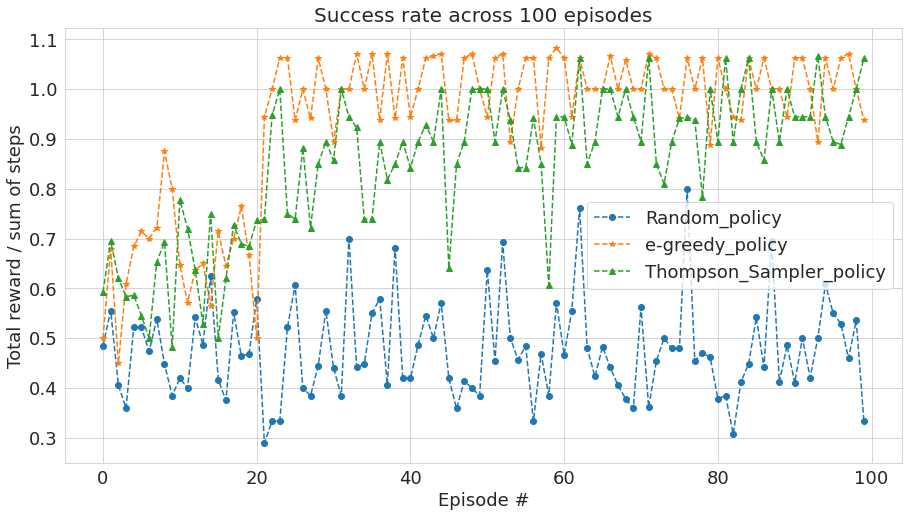

In [16]:
# Show the success rate per episode
ax_label[1] = 'Total reward / sum of steps'
plot_reward_per_episode(data['outcome'], 'gamma_rate', label, marker, (15,8))
# Legend and labels for the plot
plt.legend(fontsize=ax_size)
plt.ylabel(ax_label[1], fontsize=ax_size)
plt.xticks(fontsize=ax_size)
plt.yticks(fontsize=ax_size)
plt.xlabel(ax_label[0], fontsize=ax_size)
plt.title(f'Success rate across {no_epi} episodes', fontsize=20)
plt.show()

The success rate $\gamma^e$ is more clear to evaluate the performance of the policies. In fact, the *Random policy* presents worse success rate $\gamma^e$ for the eposides around **20** and **60**. <br>
Overall, the Epsilon-greedy and Thompson Sampler outperform when plotting the cumulative sum of $\gamma^e$

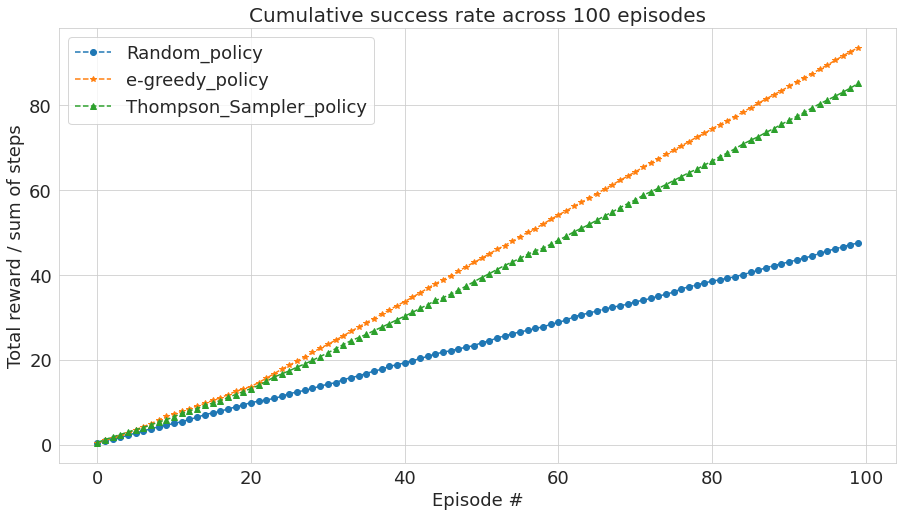

In [17]:
# Show the cumulative sum plot
ax_label[1] = 'Total reward / sum of steps'
plot_reward_per_episode(data['outcome'], 'gamma_rate', label, marker, (15,8), True)
# Legend and labels for the plot
plt.legend(fontsize=ax_size)
plt.ylabel(ax_label[1], fontsize=ax_size)
plt.xticks(fontsize=ax_size)
plt.yticks(fontsize=ax_size)
plt.xlabel(ax_label[0], fontsize=ax_size)
plt.title(f'Cumulative success rate across {no_epi} episodes', fontsize=20)
plt.show()

**Note:** Plotting the cumulative sum of the total reward $R_{Total}$ instead; this results in the a **very** similar graph for the *Epsilon-greedy* and *Thompson-Sampler* policies.
***
This shows the $R_{Total}$ has to change for a better evaluation on future simulations. <br>
## Other analysis
We should look into the *a posteriori* probablity $\theta_n$ estimated at each step $n$. Since, the $\theta_n$ is a 2D array (steps x episodes). <br>
Per episode $e$ we have:
 - time-series of $\theta_n$
 - Estimated mean and standard deviation: $\overline{\theta_n}$ and $\sigma(\theta_n)$
 - Final theta $\hat{\theta}_n$: value of $\theta_n$ in the last step $n$ (when episode ends)

**Note:** We only compute $\theta_n$ for the *Random* and *Epsilon-greedy* policies: (*Thompson-Sampler* discards the $\theta_n$ estimation)

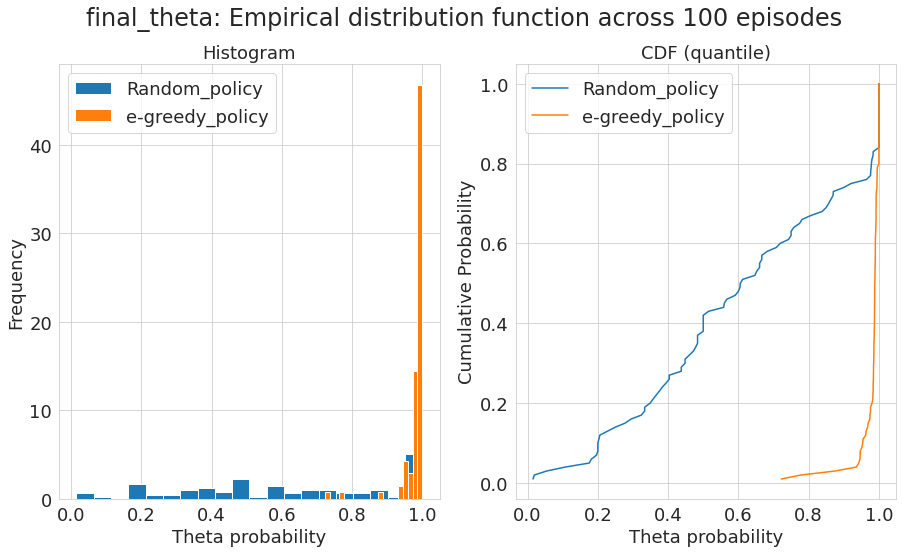

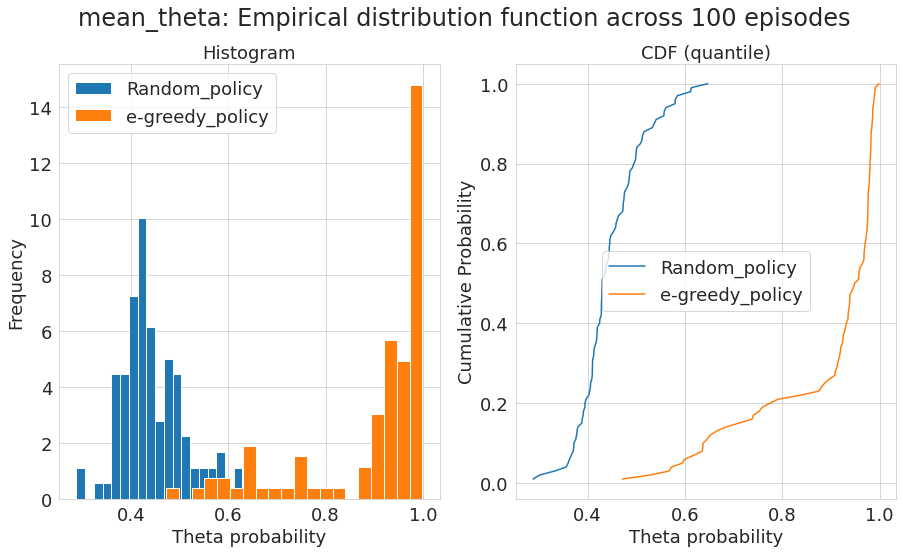

In [18]:
# Show the histogram and CDF of Theta probability for all episodes
theta_feat = ['final_theta', 'mean_theta'] # Theta_n to be seen (Final, mean, std_dev)
ax_label = ['Theta probability', 'Frequency', 'Cumulative Probability']
subplot_title = ['Histogram', 'CDF (quantile)']
for theta in theta_feat:
    fg, ax = plot_theta_per_episode(data['outcome'][0:2], theta, label, size=(15,8)) # Only plotting 'Random' and 'Epsilon-greedy'
    # Legend and labels for the plot
    [ax[i].legend(fontsize=ax_size) for i in range(len(ax))]
    [ax[i].set_xlabel(xlabel=ax_label[0], fontsize=ax_size) for i in range(len(ax))]
    [ax[i].set_ylabel(ylabel=ax_label[i+1], fontsize=ax_size) for i in range(len(ax))]
    [ax[i].tick_params(axis='x', labelsize=ax_size) for i in range(len(ax))]
    [ax[i].tick_params(axis='y', labelsize=ax_size) for i in range(len(ax))]
    # Set title
    [ax[i].set_title(subplot_title[i], fontsize=18) for i in range(len(ax))]
    fg.suptitle(f'{theta}: Empirical distribution function across {no_epi} episodes', fontsize=24)
    plt.show()


## Shape of $\theta_n$ probability
We plotted the estimated distribution (histogram and CDF) for the average probability $\overline{\theta_n}$ and final probability $\hat{\theta}_n$. Blue and orange corresponds to the *Random* and *Epsilon-greedy* polcies, respectively. We can conclude the following:
 - $\overline{\theta_n}$ presents similar histogram and CDF shape, with the *Epsilon-greedy* policy registered a translated CDF (and hist) compared to the *Random*. Showing a similar quantile distribution which backs-up the Reward function shape
 - $\hat{\theta}_n$ has a distinct shape on both policies. *Epsilon-greedy* places must of its quantile of theta around 1, so we have 80% probability of $\theta_n=1$. The same cannot be said for the *Random* policy
 - This shows that our *Epsilon-greedy* policy first explores and follows correctly the offer with highest return ($\theta_n = 1$)